# General Analysis Notebook
This notebook intents to tackle the problem of analyzing a whole batch. It mainly iterates over the many directories and process each one. Then makes a graph indicating the resulting value and the expected one. This is a neat way to understand how well is the analyzer performing generally.

## Update note
November 2018 - Modified by Gaston Snaider under the course "Taller de Programacion III" of the University of Buenos Aires.

## Requirements
This notebook requires that the root directory where reports are contains a ```description.yml``` file, indicating the various properties of the batch. Including the connection's top speed, the throttling configuration, the start time for each change and the time lapse for each throttling speed.
The network also ```requires a network_usage.log```, where the network usage speed per time is saved during the test.

## Input files
Here you should specify the input files and directories requiered for the test.

In [16]:
BATCHES_DIR = '/home/agustin/Desktop/LogsTestsMerged/TestDia3/output'
TEST_CONFIG_FILE = '/home/agustin/Desktop/LogsTestsMerged/TestDia3/description.yml'
NET_USAGE_FILE='/home/agustin/Desktop/LogsTestsMerged/TestDia3/network_usage.log'


## Imports and setup

In [35]:
NET_USAGE_SEPARATOR='|'

# Setup and import everything
%matplotlib notebook
%matplotlib inline

import datetime
import math
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt

from processor.reports.report_handler import ReportHandler
from processor.analysis.analysis import Analyzer

from IPython.display import display

base_directory = BATCHES_DIR

## Test configuration
This is the configuration used during the test, as per the yaml file in TEST_CONFIG_FILE

In [25]:
with open(TEST_CONFIG_FILE) as fp:
    test_config = yaml.safe_load(fp)
test_config

{'intervals': [{'duration_minutes': 30, 'speed_percentage': 0},
  {'duration_minutes': 30, 'speed_percentage': 25},
  {'duration_minutes': 30, 'speed_percentage': 50},
  {'duration_minutes': 30, 'speed_percentage': 75},
  {'duration_minutes': 30, 'speed_percentage': 100},
  {'duration_minutes': 30, 'speed_percentage': 75},
  {'duration_minutes': 30, 'speed_percentage': 50},
  {'duration_minutes': 30, 'speed_percentage': 25},
  {'duration_minutes': 30, 'speed_percentage': 0}],
 'max_speed_kbps': 40000,
 'network_interface': 'wlan0',
 'start_time': 1699848240.021103}

## Measued and expected network usage
Here we calculate the network usage as measured by the TiX system, and the expected network usage based on the test configuration.

In [26]:
def get_analyzer_results(reports_batch_dir):
    rh = ReportHandler(os.path.join(base_directory, reports_batch_dir))
    ip, obs_set = rh.get_ip_and_processable_observations()
    if ip is None and obs_set is None:
        raise ValueError('Reports batch directory {} has no reports to use!'.format(reports_batch_dir))
    analyzer = Analyzer(obs_set)
    results = analyzer.get_results()
    return results

def get_expected_usage(batch_start_time, batch_end_time):
    batch_starting_conf, batch_ending_conf = None, None
    test_start_epoch = test_config['start_time']
    experiment_start_epoch = test_start_epoch
    for experiment_configuration in test_config['intervals']:
        experiment_lapse = experiment_configuration['duration_minutes'] * 60
        experiment_start = experiment_start_epoch
        experiment_end = experiment_start_epoch + experiment_lapse
        if experiment_start <= batch_start_time < experiment_end:
            batch_starting_conf = experiment_configuration
            batch_starting_conf_start_epoch = experiment_start
        if experiment_start <= batch_end_time < experiment_end:
            batch_ending_conf = experiment_configuration
            batch_ending_conf_start_epoch = experiment_start
        if batch_starting_conf is not None and batch_ending_conf is not None:
            break
        # Increment the start epoch for the next experiment.
        experiment_start_epoch = experiment_end

    print("Batch_Starting_Conf: {}".format(batch_starting_conf))
    print("Batch_Ending_Conf: {}".format(batch_ending_conf))   
    if batch_starting_conf is None and batch_ending_conf is None:
        return None
#         raise ValueError('Batch for start time: {} and end time {} has no config.'.format(batch_start_time,
#                                                                                           batch_end_time))
    if batch_ending_conf is None:
        expected_usage = batch_starting_conf['speed_percentage'] / 100
    elif batch_starting_conf is None:
        expected_usage = batch_ending_conf['speed_percentage'] / 100
    elif batch_starting_conf['speed_percentage'] / 100 == batch_ending_conf['speed_percentage'] / 100:
        expected_usage = batch_starting_conf['speed_percentage'] / 100
    else:
        batch_lapse = batch_end_time - batch_start_time
        batch_starting_conf_lapse = batch_starting_conf_start_epoch + batch_starting_conf['duration_minutes']*60 - batch_start_time
        batch_ending_conf_lapse = batch_end_time - batch_ending_conf_start_epoch
        expected_usage = ((batch_starting_conf_lapse / batch_lapse) * batch_starting_conf['speed_percentage'] / 100 +
            (batch_ending_conf_lapse / batch_lapse) * batch_ending_conf['speed_percentage'] / 100)
    print("Expected Usage: {}".format(expected_usage))
    return expected_usage

def get_expected_usage2():
    columns = ["start_time", "end_time", "expected_usage"]
    test_data = pd.DataFrame(columns=columns)
    test_start = test_config['start_time']
    for test_interval in test_config['intervals']:
        interval_duration = test_interval['duration_minutes'] * 60
        end_time = test_start + interval_duration
        interval_df = pd.DataFrame([(test_start, end_time, test_interval['speed_percentage']/100)], columns=columns)
        interval_df['start_time'] = pd.to_datetime(interval_df['start_time'],unit='s')
        interval_df['end_time'] = pd.to_datetime(interval_df['end_time'],unit='s')
        test_data = test_data.append(interval_df, ignore_index=True)
        test_start = end_time
    test_data['start_time'] = test_data['start_time'] - pd.Timedelta('03:00:00')
    test_data['end_time'] = test_data['end_time'] - pd.Timedelta('03:00:00')
    return test_data
    

In [27]:
data2 = get_expected_usage2()
data2 = data2.sort_values(by=['start_time'])
display(data2)

plt.figure()
plt.step( data2['end_time'],  data2['expected_usage'], label='pre (default)')
#plt.plot(data2['start_time'], data2['expected_usage'])
plt.xlabel('time')
plt.ylabel('Network usage')
plt.title('Test results')
plt.legend(['Expected downstream usage'])
plt.show()


,start_time,end_time,expected_usage
0,2023-11-13 01:04:00.021102848,2023-11-13 01:34:00.021102848,0.00
1,2023-11-13 01:34:00.021102848,2023-11-13 02:04:00.021102848,0.25
2,2023-11-13 02:04:00.021102848,2023-11-13 02:34:00.021102848,0.50
3,2023-11-13 02:34:00.021102848,2023-11-13 03:04:00.021102848,0.75
4,2023-11-13 03:04:00.021102848,2023-11-13 03:34:00.021102848,1.00
5,2023-11-13 03:34:00.021102848,2023-11-13 04:04:00.021102848,0.75
6,2023-11-13 04:04:00.021102848,2023-11-13 04:34:00.021102848,0.50
7,2023-11-13 04:34:00.021102848,2023-11-13 05:04:00.021102848,0.25
8,2023-11-13 05:04:00.021102848,2023-11-13 05:34:00.021102848,0.00


<IPython.core.display.Javascript object>

In [28]:
columns = ['batch_start_timestamp', 'batch_end_timestamp',
           'batch_start_time', 'batch_end_time',
           'downstream_hurst_rs', 'downstream_hurst_wavelet',
           'downstream_quality', 'downstream_usage',
           'upstream_hurst_rs', 'upstream_hurst_wavelet',
           'upstream_quality', 'upstream_usage',
           'expected_downstream_usage', 'error', 'relative_error']
data = pd.DataFrame(columns=columns)
for reports_batch_dir in sorted(os.listdir(base_directory)):
    reports_batch_dir_path = os.path.join(base_directory, reports_batch_dir)
    if not os.path.isdir(reports_batch_dir_path): continue
    print("BATCH DIR: {}".format(reports_batch_dir))
    results = get_analyzer_results(reports_batch_dir_path)
    print("RESULTS: {}".format(results))
    batch_start_time = int(reports_batch_dir)
    batch_end_time = results['timestamp']
    expected_usage = get_expected_usage(batch_start_time, batch_end_time)
    if expected_usage is None: continue
    df_ = pd.DataFrame([(batch_start_time, batch_end_time, 
                         datetime.datetime.fromtimestamp(batch_start_time),
                         datetime.datetime.fromtimestamp(batch_end_time),
                         results['downstream']['hurst']['rs'], results['downstream']['hurst']['wavelet'],
                         results['downstream']['quality'], results['downstream']['usage'], 
                         results['upstream']['hurst']['rs'], results['upstream']['hurst']['wavelet'],
                         results['upstream']['quality'], results['upstream']['usage'],
                         expected_usage, 
                         math.fabs(expected_usage - results['downstream']['usage']), 
                         (math.fabs(expected_usage - results['downstream']['usage']) / expected_usage) 
                         if expected_usage != 0 else math.fabs(expected_usage - results['downstream']['usage']))
                       ], 
                       columns=columns)
    data = data.append(df_)
    batch_start_time += batch_end_time - batch_start_time
data = data.sort_values(by=['batch_start_time']).reset_index(drop=True)
display(data)

BATCH DIR: 1699848242
Processable_reports []


/home/agustin/Desktop/FIUBA/FIUBA/TPP/TestTix/tix-time-processor/processor/hurst.py:300: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  fit, coef1 = numpy.linalg.lstsq(A, log10_y)[0]
/home/agustin/Desktop/FIUBA/FIUBA/TPP/TestTix/tix-time-processor/processor/hurst.py:303: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  fitH, coef2 = numpy.linalg.lstsq(B, log10_yx)[0]
/home/agustin/Desktop/FIUBA/FIUBA/TPP/TestTix/tix-time-processor/processor/hurst.py:197: FutureWarning: `rcond` parameter will change to the default of machin

RESULTS: {'timestamp': 1699849317, 'upstream': {'usage': 0.145610278372591, 'quality': 1.0, 'hurst': {'wavelet': -0.2066979048964931, 'rs': 0.4799328987622205}}, 'downstream': {'usage': 0.09330143540669857, 'quality': 1.0, 'hurst': {'wavelet': 0.3802919876894775, 'rs': 0.5580788729807142}}}
Batch_Starting_Conf: None
Batch_Ending_Conf: {'duration_minutes': 30, 'speed_percentage': 0}
Expected Usage: 0.0
BATCH DIR: 1699848791
Processable_reports []
RESULTS: {'timestamp': 1699849811, 'upstream': {'usage': 0.17204301075268819, 'quality': 1.0, 'hurst': {'wavelet': 0.6610809343778518, 'rs': 0.5042565518535826}}, 'downstream': {'usage': 0.19002375296912113, 'quality': 1.0, 'hurst': {'wavelet': 0.3991905966760021, 'rs': 0.573248968672598}}}
Batch_Starting_Conf: {'duration_minutes': 30, 'speed_percentage': 0}
Batch_Ending_Conf: {'duration_minutes': 30, 'speed_percentage': 0}
Expected Usage: 0.0
BATCH DIR: 1699849339
Processable_reports []
RESULTS: {'timestamp': 1699850030, 'upstream': {'usage': 

,batch_start_timestamp,batch_end_timestamp,batch_start_time,batch_end_time,downstream_hurst_rs,downstream_hurst_wavelet,downstream_quality,downstream_usage,upstream_hurst_rs,upstream_hurst_wavelet,upstream_quality,upstream_usage,expected_downstream_usage,error,relative_error
0,1696905000,1699849317,2023-10-09 23:30:00,2023-11-13 01:21:57,0.558079,0.380292,1.0,0.093301,0.479933,-0.206698,1.0,0.145610,0.000000,0.093301,0.093301
1,1699849317,1699849811,2023-11-13 01:21:57,2023-11-13 01:30:11,0.573249,0.399191,1.0,0.190024,0.504257,0.661081,1.0,0.172043,0.000000,0.190024,0.190024
2,1699849811,1699850030,2023-11-13 01:30:11,2023-11-13 01:33:50,0.499857,0.446598,1.0,1.310112,0.543961,0.446600,1.0,1.340476,0.000000,1.310112,1.310112
3,1699850030,1699850534,2023-11-13 01:33:50,2023-11-13 01:42:14,0.530662,0.468207,1.0,0.632696,0.569792,0.504884,1.0,1.124434,0.245029,0.387667,1.582126
4,1699850534,1699851097,2023-11-13 01:42:14,2023-11-13 01:51:37,0.525134,0.322385,1.0,0.390558,0.604676,0.365295,1.0,1.169048,0.250000,0.140558,0.562232
5,1699851097,1699851834,2023-11-13 01:51:37,2023-11-13 02:03:54,0.520753,0.557205,1.0,0.334135,0.523304,0.185355,1.0,0.199179,0.250000,0.084135,0.336538
6,1699851834,1699852290,2023-11-13 02:03:54,2023-11-13 02:11:30,0.530102,0.457719,1.0,0.270955,0.588195,0.633167,1.0,0.240781,0.496699,0.225744,0.454488
7,1699852290,1699852591,2023-11-13 02:11:30,2023-11-13 02:16:31,0.541536,0.651267,1.0,0.162291,0.567321,0.488518,1.0,0.201717,0.500000,0.337709,0.675418
8,1699852591,1699853678,2023-11-13 02:16:31,2023-11-13 02:34:38,0.522312,0.496703,1.0,0.275229,0.512231,0.366574,1.0,0.185745,0.508735,0.233505,0.458992
9,1699853678,1699853980,2023-11-13 02:34:38,2023-11-13 02:39:40,0.566171,0.626469,1.0,0.158009,0.568007,0.382834,1.0,0.132383,0.750000,0.591991,0.789322


## Actual network usage
Here we process the data from NET_USAGE_FILE, which corresponds to the network usage measured in the specified network_interface during the test.

We group the network usage data into batches so that they match the structure of the batches from the TiX measurements.

NOTE: for the comparison between the network usage and the TiX measurements to work, it is required that the network usage was measured once per minute on the test, and that the measurements started at the same time as the TiX client.

In [29]:
# We group 9 network_usage samples because as of right now, the batches from TiX logs are 
# generated with an interval of aproximately 9 minutes in between.
NET_USAGE_SAMPLES_PER_BATCH = 9

net_usage_time = []
net_usage_speed = []
grouped_net_usage_time = []
grouped_net_usage_speed = []

net_usage_per_batch_time = []
net_usage_per_batch_speed = []


with open(NET_USAGE_FILE) as net_usage_file:
  # Skip header
  next(net_usage_file)
  
  for line in net_usage_file:
    (epoch, speed) = line.split(NET_USAGE_SEPARATOR)
    usage_timestamp =  float(epoch)
    speed_kbps = float(speed)
    net_usage_per_batch_time.append(usage_timestamp)
    net_usage_per_batch_speed.append(speed_kbps)
    
    if (len(net_usage_per_batch_speed) == NET_USAGE_SAMPLES_PER_BATCH):
      net_usage_time.extend(net_usage_per_batch_time)
      net_usage_speed.extend(net_usage_per_batch_speed)
      
      grouped_net_usage_time.append(net_usage_per_batch_time[0])
      grouped_net_usage_speed.append(sum(net_usage_per_batch_speed) / len(net_usage_per_batch_speed))
      
      net_usage_per_batch_time = []
      net_usage_per_batch_speed = []

net_usage_time = [datetime.datetime.fromtimestamp(timestamp) for timestamp in net_usage_time]
grouped_net_usage_time = [datetime.datetime.fromtimestamp(timestamp) for timestamp in grouped_net_usage_time]


## Test results

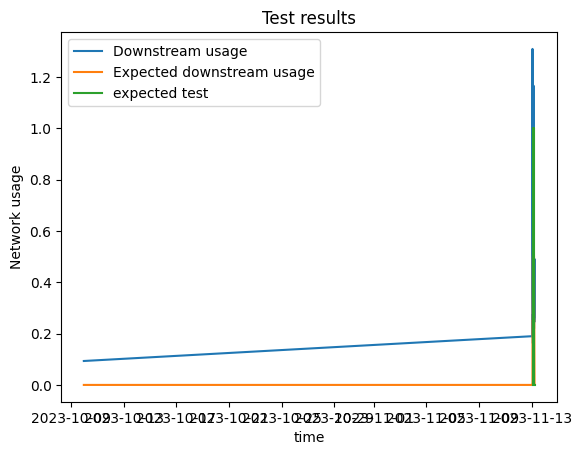

In [36]:
plt.figure()
plt.plot(data['batch_start_time'], data['downstream_usage'])
plt.plot(data['batch_start_time'], data['expected_downstream_usage'])
plt.step(data2['end_time'],  data2['expected_usage'])
plt.xlabel('time')
plt.ylabel('Network usage')
plt.title('Test results')
plt.legend(['Downstream usage', 'Expected downstream usage', 'expected test'])
plt.show()

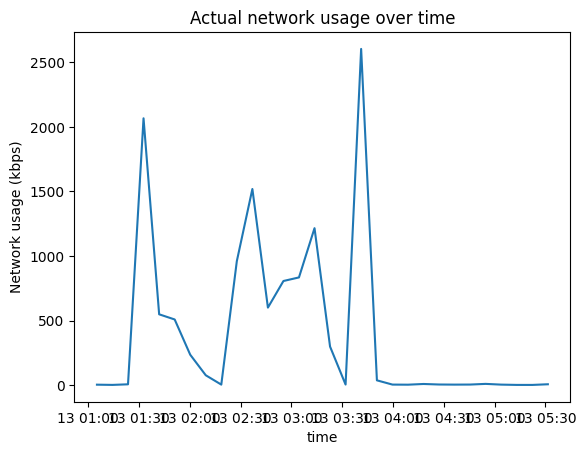

In [37]:
plt.figure()
plt.plot(grouped_net_usage_time,grouped_net_usage_speed)
plt.xlabel('time')
plt.ylabel('Network usage (kbps)')
plt.title('Actual network usage over time')
plt.show()

In [34]:
normalized_net_usage = [speed_kbps / test_config['max_speed_kbps'] for speed_kbps in grouped_net_usage_speed]
print(grouped_net_usage_time)
print(grouped_net_usage_speed)
print(normalized_net_usage)
plt.figure()
plt.plot(data['batch_start_time'], data['downstream_usage'])
plt.plot(data['batch_start_time'], data['expected_downstream_usage'])
plt.plot(grouped_net_usage_time, normalized_net_usage)
plt.xlabel('time')
plt.ylabel('Network usage percentage')
plt.title('Test results')
plt.legend(['Measured downstream usage', 'Expected downstream usage', 'Actual network usage'])
plt.show()

[datetime.datetime(2023, 11, 13, 1, 5, 11, 147532), datetime.datetime(2023, 11, 13, 1, 14, 21, 474466), datetime.datetime(2023, 11, 13, 1, 23, 31, 764938), datetime.datetime(2023, 11, 13, 1, 32, 42, 23082), datetime.datetime(2023, 11, 13, 1, 41, 55, 367163), datetime.datetime(2023, 11, 13, 1, 51, 5, 611018), datetime.datetime(2023, 11, 13, 2, 0, 15, 882991), datetime.datetime(2023, 11, 13, 2, 9, 27, 189361), datetime.datetime(2023, 11, 13, 2, 18, 37, 422617), datetime.datetime(2023, 11, 13, 2, 27, 47, 710052), datetime.datetime(2023, 11, 13, 2, 36, 58, 984823), datetime.datetime(2023, 11, 13, 2, 46, 9, 278716), datetime.datetime(2023, 11, 13, 2, 55, 19, 475636), datetime.datetime(2023, 11, 13, 3, 4, 29, 705046), datetime.datetime(2023, 11, 13, 3, 13, 40, 957403), datetime.datetime(2023, 11, 13, 3, 22, 51, 354120), datetime.datetime(2023, 11, 13, 3, 32, 1, 525139), datetime.datetime(2023, 11, 13, 3, 41, 12, 835418), datetime.datetime(2023, 11, 13, 3, 50, 31, 830232), datetime.datetime(2

<IPython.core.display.Javascript object>

## Error between expected network usage and measured network usage 

In [11]:
display(data[['error', 'relative_error']].describe(include='all'))

,error,relative_error
count,18.000000,18.000000
mean,0.484295,0.817492
std,0.377465,0.845385
min,0.000538,0.002151
25%,0.108107,0.258399
50%,0.421185,0.900997
75%,0.854240,0.944649
max,1.021378,3.817102


<AxesSubplot:title={'center':'Error with expected usage'}, xlabel='batch_start_time'>

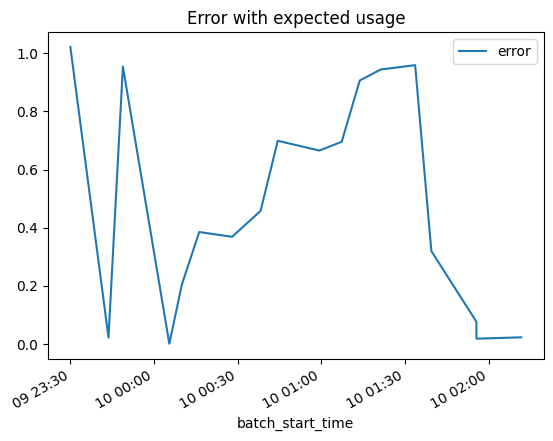

In [12]:
data.plot(x='batch_start_time', y='error', kind='line', title='Error with expected usage')

<AxesSubplot:title={'center':'Relative error with expected usage'}, xlabel='batch_start_time'>

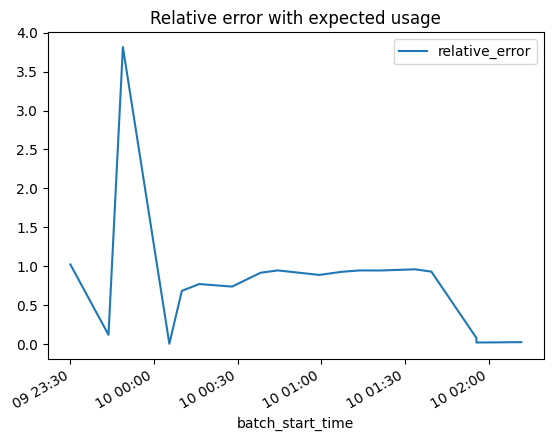

In [13]:
data.plot(x='batch_start_time', y='relative_error', kind='line', title='Relative error with expected usage')

## Error between expected network usage and actual network usage

In [14]:
error_times = []
errors = []
relative_errors = []

# We use this so that the relative error doesn't skyrocket when dividing by a small number close to zero.
actual_usage_zero_threshold = 0.05

for time, measured_usage, actual_usage in zip(data['batch_start_time'], data['downstream_usage'], normalized_net_usage):
  error_times.append(time)
  errors.append(math.fabs(actual_usage - measured_usage))
  relative_errors.append((math.fabs(actual_usage - measured_usage) / actual_usage) 
                          if actual_usage > actual_usage_zero_threshold else math.fabs(actual_usage - measured_usage))


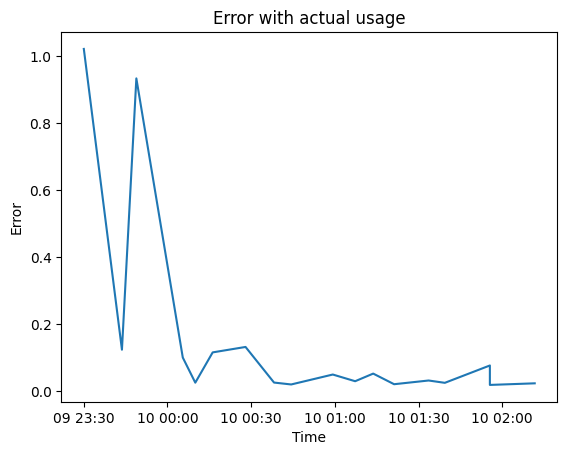

In [15]:
plt.figure()
plt.plot(error_times, errors)
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Error with actual usage')
plt.show()

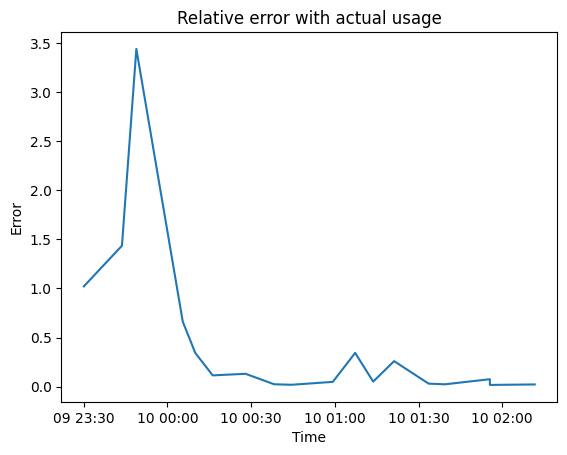

In [16]:
plt.figure()
plt.plot(error_times, relative_errors)
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Relative error with actual usage')
plt.show()